In [1]:
import numpy as np
import pandas as pd

%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

%pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading Data

### Parquets

In [2]:
taxi_trip_df = pd.read_parquet('yellow_tripdata_2024-12.parquet')

fhv_trip_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/fhvhv_tripdata_2024-12.parquet')

taxi_zone_df = pd.read_csv('https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv')

### CSVs

In [3]:
subway_ridership_df = pd.read_csv('MTA_Subway_Hourly_Ridership__2020-2024_20250325.csv')

bus_ridership_df = pd.read_csv('MTA_Bus_Hourly_Ridership__2020-2024_20250325.csv')

### APIs

In [4]:
# Obtaining Url with SoQL Queries

permitted_events_historical_url = (
    "https://data.cityofnewyork.us/resource/bkfu-528j.json?" #json file
    "$limit=2000&" #limit
    "$where=start_date_time%20%3E%3D%20%272024-12-01T00:00:00%27" #start_date_time in Dec 2024
    "%20AND%20start_date_time%20%3C%20%272025-01-01T00:00:00%27"
    )

# Read JSON

permitted_events_historical_df = pd.read_json(permitted_events_historical_url)

permitted_events_current_df = pd.read_json('https://data.cityofnewyork.us/resource/tvpp-9vvx.json?$limit=2000')

In [5]:
permitted_events_current_df.head(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
0,808693,Celebration,2025-05-24 11:00:00,2025-05-24 15:00:00,Parks Department,Special Event,Brooklyn,Marine Park: Picnic Area- E. 31 St,N/A,"18,","63,",NaN
1,817694,Homecrest Playground Family Day,2025-04-27 12:00:00,2025-04-27 15:00:00,Parks Department,Special Event,Brooklyn,Homecrest Playground: Playground,N/A,"15,","61,",NaN
2,810439,Miscellaneous,2025-05-15 09:00:00,2025-05-15 14:00:00,Parks Department,Special Event,Brooklyn,Dyker Beach Park: Dyker 14th Ave-Softball-01 ...,N/A,"10,","68,",NaN
3,819895,Celebration,2025-09-30 12:00:00,2025-09-30 13:00:00,Parks Department,Special Event,Manhattan,"Central Park: Wagner Cove ,Central Park: Che...",N/A,"64,","22,",NaN
4,819269,Celebration,2025-07-12 15:00:00,2025-07-12 17:00:00,Parks Department,Special Event,Manhattan,Central Park: Cop Cot,N/A,"64,","22,",NaN
5,823456,Soccer - Non Regulation,2025-06-21 12:00:00,2025-06-21 16:00:00,Parks Department,Sport - Youth,Manhattan,Riverside Park: 101st St-Soccer-04 C,N/A,"07,","24,",NaN
6,808438,Celebration,2025-06-07 14:00:00,2025-06-07 16:00:00,Parks Department,Special Event,Manhattan,Central Park: Cop Cot,N/A,"64,","22,",NaN
7,809809,Celebration,2025-08-24 15:00:00,2025-08-24 17:00:00,Parks Department,Special Event,Manhattan,Central Park: Ladies' Pavilion,N/A,"64,","22,",NaN
8,816468,Miscellaneous,2025-05-28 10:00:00,2025-05-28 13:30:00,Parks Department,Special Event,Queens,Astoria Park: Great Lawn 02 Ditmars Blvd,N/A,"1,","114,",NaN
9,815089,Miscellaneous,2025-05-29 10:00:00,2025-05-29 13:00:00,Parks Department,Special Event,Queens,Juniper Valley Park: Football-01,N/A,"05,","104,",NaN


In [6]:
permitted_events_historical_df.sample(10)

,event_id,event_name,start_date_time,end_date_time,event_agency,event_type,event_borough,event_location,street_closure_type,community_board,police_precinct,event_street_side
1039,811417,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 19:00:00,Parks Department,Sport - Youth,Manhattan,Randall's Island Park: Wards Meadow Fields-Soc...,N/A,"11,","25,",NaN
384,812163,Soccer - Non Regulation,2024-12-01 07:00:00,2024-12-01 09:00:00,Parks Department,Sport - Adult,Queens,Frank Principe Park / Maurice Park: Soccer-03,N/A,"5,","104,",NaN
1707,816538,Football - Youth,2024-12-01 09:00:00,2024-12-01 21:00:00,Parks Department,Sport - Youth,Queens,Roy Wilkins Park: Soccer/Football-01,N/A,"12,","113,",NaN
680,811737,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 18:00:00,Parks Department,Sport - Youth,Manhattan,Randall's Island Park: Wards Meadow Fields-Soc...,N/A,"11,","25,",NaN
1199,818071,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 12:00:00,Parks Department,Sport - Youth,Manhattan,Eugene McCabe Field: Soccer-01,N/A,"11,","25,",NaN
620,811491,Soccer - Non Regulation,2024-12-01 08:00:00,2024-12-01 09:00:00,Parks Department,Sport - Adult,Queens,Kennedy Playground /Raymond O'Connor: Soccer-01,N/A,"11,","111,",NaN
1395,743881,Santa Strut 5K and 10K,2024-12-01 09:00:00,2024-12-01 11:00:00,Parks Department,Special Event,Queens,Rockaway Beach Boardwalk: Beach 108th Street,N/A,"14,","100,",NaN
1210,812178,Soccer -Regulation,2024-12-01 08:00:00,2024-12-01 17:00:00,Parks Department,Sport - Youth,Staten Island,Cpl. Thompson Park: Soccer-01,N/A,"01,","120,",NaN
458,746602,GallopNYC Therapeutic Horsemanship at Prospect...,2024-12-01 08:00:00,2024-12-01 17:00:00,Parks Department,Special Event,Brooklyn,Parade Ground: Bowling Green Lawn,N/A,"14,","70,",NaN
1603,811365,Celebration,2024-12-01 09:00:00,2024-12-01 11:00:00,Parks Department,Special Event,Manhattan,Central Park: Bethesda Fountain Terrace,N/A,"64,","22,",NaN


In [7]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
3098338,12/14/2024 09:00:00 AM,S42,omny,OMNY - Fair Fare,0,0
202060,12/01/2024 08:00:00 PM,X17J,metrocard,OMNY - Seniors & Disability,0,0
2268049,12/10/2024 07:00:00 PM,BXM8,metrocard,OMNY - Students,0,0
6729713,12/30/2024 01:00:00 AM,M99,omny,Metrocard - Seniors & Disability,0,0
3019887,12/14/2024 01:00:00 AM,B62,metrocard,OMNY - Students,0,0
1781666,12/08/2024 04:00:00 PM,Q35,omny,OMNY - Other,0,0
1900189,12/09/2024 04:00:00 AM,B82,omny,Metrocard - Other,0,0
509228,12/03/2024 04:00:00 AM,BX20,metrocard,OMNY - Other,0,0
2361105,12/11/2024 04:00:00 AM,B100,metrocard,OMNY - Full Fare,0,0
2444952,12/11/2024 01:00:00 PM,Q69,metrocard,Metrocard - Unlimited 7-Day,26,0


In [8]:
subway_ridership_df.sample(10)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
266758,12/04/2024 09:00:00 AM,subway,179,"Nostrand Av (A,C)",Brooklyn,metrocard,Metrocard - Unlimited 7-Day,46,0,40.680440,-73.950424,POINT (-73.950424 40.68044)
1340587,12/17/2024 06:00:00 PM,subway,150,155 St (C),Manhattan,omny,OMNY - Students,10,0,40.830517,-73.941510,POINT (-73.94151 40.830517)
4752,12/01/2024 02:00:00 AM,subway,123,Grand St (L),Brooklyn,metrocard,Metrocard - Fair Fare,1,0,40.711926,-73.940670,POINT (-73.94067 40.711926)
38628,12/01/2024 01:00:00 PM,subway,5,"36 Av (N,W)",Queens,metrocard,Metrocard - Unlimited 30-Day,20,0,40.756805,-73.929570,POINT (-73.92957 40.756805)
1568090,12/20/2024 01:00:00 PM,subway,416,Wakefield-241 St (2),Bronx,omny,OMNY - Full Fare,48,0,40.903126,-73.850620,POINT (-73.85062 40.903126)
484717,12/07/2024 12:00:00 AM,subway,383,183 St (4),Bronx,metrocard,Metrocard - Unlimited 7-Day,3,0,40.858406,-73.903880,POINT (-73.90388 40.858406)
883194,12/12/2024 01:00:00 AM,subway,328,WTC Cortlandt (1),Manhattan,metrocard,Metrocard - Unlimited 7-Day,3,0,40.711834,-74.012190,POINT (-74.01219 40.711834)
1896833,12/24/2024 05:00:00 PM,subway,66,18 Av (D),Brooklyn,omny,OMNY - Full Fare,74,6,40.607952,-74.001740,POINT (-74.00174 40.607952)
918857,12/12/2024 12:00:00 PM,subway,447,Flushing-Main St (7),Queens,metrocard,Metrocard - Seniors & Disability,262,87,40.759600,-73.830030,POINT (-73.83003 40.7596)
976207,12/13/2024 06:00:00 AM,subway,623,"Canal St (J,N,Q,R,W,Z,6)",Manhattan,metrocard,Metrocard - Full Fare,15,0,40.719530,-73.999890,POINT (-73.99989 40.71953)


# Data Aggreration

### Filtering

Only include data from December 2024

In [9]:
taxi_trip_df = taxi_trip_df.loc[
    (taxi_trip_df['tpep_pickup_datetime'].dt.year == 2024) &
    (taxi_trip_df['tpep_pickup_datetime'].dt.month == 12)
    ]

taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [10]:
fhv_trip_df = fhv_trip_df.loc[
    (fhv_trip_df['request_datetime'].dt.year == 2024) &
    (fhv_trip_df['request_datetime'].dt.month == 12)
    ]

fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


## Data Manipulation

### FHV DF

In [11]:
fhv_trip_df.head(10)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2024-12-01 00:26:25,2024-12-01 00:28:18,2024-12-01 00:30:18,2024-12-01 00:45:00,81,213,6.160,...,1.24,0.0,0.0,0.0,20.80,N,N,N,N,N
1,HV0003,B03404,B03404,2024-12-01 00:43:16,2024-12-01 00:46:46,2024-12-01 00:47:39,2024-12-01 00:55:03,213,213,1.810,...,0.95,0.0,0.0,0.0,10.62,N,N,N,N,N
2,HV0003,B03404,B03404,2024-12-01 00:02:09,2024-12-01 00:07:28,2024-12-01 00:09:29,2024-12-01 00:20:48,221,221,1.460,...,0.99,0.0,0.0,0.0,9.59,Y,N,N,N,N
3,HV0003,B03404,B03404,2024-12-01 00:20:28,2024-12-01 00:27:04,2024-12-01 00:29:05,2024-12-01 00:35:57,245,245,1.830,...,1.07,0.0,0.0,0.0,8.00,N,N,N,N,N
4,HV0003,B03404,B03404,2024-12-01 00:32:23,2024-12-01 00:35:52,2024-12-01 00:36:43,2024-12-01 01:05:17,245,109,9.290,...,3.86,0.0,0.0,0.0,30.79,N,N,N,N,N
5,HV0003,B03404,B03404,2024-12-01 00:07:55,2024-12-01 00:11:20,2024-12-01 00:11:29,2024-12-01 00:15:25,89,89,0.660,...,0.78,0.0,0.0,0.0,5.39,N,N,N,N,N
6,HV0003,B03404,B03404,2024-12-01 00:16:48,2024-12-01 00:21:08,2024-12-01 00:21:53,2024-12-01 00:25:22,89,89,0.470,...,0.79,0.0,0.0,5.0,5.39,N,N,N,N,N
7,HV0003,B03404,B03404,2024-12-01 00:46:41,2024-12-01 00:47:08,2024-12-01 00:47:47,2024-12-01 01:13:55,189,91,5.660,...,2.53,0.0,0.0,0.0,22.93,N,N,N,N,N
8,HV0005,B03406,None,2024-12-01 00:14:47,NaT,2024-12-01 00:20:11,2024-12-01 00:28:45,112,255,1.395,...,0.65,0.0,0.0,0.0,7.45,N,N,N,N,Y
9,HV0005,B03406,None,2024-12-01 00:26:21,NaT,2024-12-01 00:33:49,2024-12-01 00:39:07,255,80,0.931,...,0.57,0.0,0.0,2.0,5.47,N,N,N,N,Y


In [12]:
fhs_code = {'HV0002':'Juno', 'HV0003':'Uber', 'HV0004':'Via', 'HV0005':'Lyft'}

# Create a new column for For-Hire Services
fhv_trip_df['service_provider'] = fhv_trip_df['hvfhs_license_num'].replace(fhs_code)

# Remove unnecessary columns
fhv_trip_df.drop(columns=['hvfhs_license_num',
                          'dispatching_base_num','originating_base_num',
                          'shared_request_flag','shared_match_flag','access_a_ride_flag',
                          'wav_request_flag','wav_match_flag','DOLocationID','on_scene_datetime','dropoff_datetime','trip_miles','trip_time',
                          'base_passenger_fare','tolls','bcf','sales_tax','tips','driver_pay','airport_fee'
                          ], 
                          inplace=True)

fhv_trip_df.rename(columns={'pickup_datetime':'transit_timestamp'},inplace=True)

fhv_trip_df.sample(10)

,request_datetime,transit_timestamp,PULocationID,congestion_surcharge,service_provider
5641019,2024-12-08 23:49:38,2024-12-08 23:51:28,140,2.75,Uber
15915265,2024-12-23 00:56:00,2024-12-23 00:57:51,31,0.00,Uber
20206141,2024-12-30 17:53:40,2024-12-30 17:55:23,80,0.00,Lyft
6992740,2024-12-11 03:19:16,2024-12-11 03:21:33,218,0.00,Uber
3422171,2024-12-06 06:59:40,2024-12-06 07:02:39,48,2.75,Lyft
20810518,2024-12-31 19:35:04,2024-12-31 19:39:42,216,0.00,Uber
14556829,2024-12-21 08:28:04,2024-12-21 08:36:40,241,0.00,Uber
18641686,2024-12-27 22:16:51,2024-12-27 22:19:13,80,0.00,Uber
7000105,2024-12-11 03:56:51,2024-12-11 04:00:49,211,2.75,Uber
9765431,2024-12-14 15:47:42,2024-12-14 15:51:30,132,2.75,Lyft


In [13]:
fhv_trip_df['waiting_time'] = fhv_trip_df['transit_timestamp'].dt.minute - fhv_trip_df['request_datetime'].dt.minute

fhv_trip_df.head(10)

,request_datetime,transit_timestamp,PULocationID,congestion_surcharge,service_provider,waiting_time
0,2024-12-01 00:26:25,2024-12-01 00:30:18,81,0.0,Uber,4
1,2024-12-01 00:43:16,2024-12-01 00:47:39,213,0.0,Uber,4
2,2024-12-01 00:02:09,2024-12-01 00:09:29,221,0.0,Uber,7
3,2024-12-01 00:20:28,2024-12-01 00:29:05,245,0.0,Uber,9
4,2024-12-01 00:32:23,2024-12-01 00:36:43,245,0.0,Uber,4
5,2024-12-01 00:07:55,2024-12-01 00:11:29,89,0.0,Uber,4
6,2024-12-01 00:16:48,2024-12-01 00:21:53,89,0.0,Uber,5
7,2024-12-01 00:46:41,2024-12-01 00:47:47,189,0.0,Uber,1
8,2024-12-01 00:14:47,2024-12-01 00:20:11,112,0.0,Lyft,6
9,2024-12-01 00:26:21,2024-12-01 00:33:49,255,0.0,Lyft,7


In [14]:
print(fhv_trip_df['waiting_time'].isnull().sum() / len(fhv_trip_df)* 100)

0.0


In [15]:
fhv_trip_df.drop(columns=['request_datetime'],inplace=True)

### Trips DF

In [16]:
taxi_trip_df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-12-01 00:12:27,2024-12-01 00:31:12,1.0,9.76,1.0,N,138,33,1,38.0,6.0,0.5,4.72,0.00,1.0,51.97,0.0,1.75
2,2,2024-12-01 00:50:35,2024-12-01 01:24:46,4.0,20.07,2.0,N,132,236,2,70.0,0.0,0.5,0.00,6.94,1.0,82.69,2.5,1.75
3,2,2024-12-01 00:18:16,2024-12-01 00:33:16,3.0,2.34,1.0,N,142,186,1,15.6,1.0,0.5,4.12,0.00,1.0,24.72,2.5,0.00
4,2,2024-12-01 00:56:13,2024-12-01 01:18:25,1.0,5.05,1.0,N,107,80,1,26.8,1.0,0.5,5.00,0.00,1.0,36.80,2.5,0.00
5,1,2024-12-01 00:21:17,2024-12-01 00:37:22,1.0,4.30,1.0,N,249,141,1,20.5,3.5,0.5,5.10,0.00,1.0,30.60,2.5,0.00
6,2,2024-12-01 00:04:53,2024-12-01 00:31:03,1.0,7.66,1.0,N,186,52,1,35.2,1.0,0.5,8.04,0.00,1.0,48.24,2.5,0.00
7,1,2024-12-01 00:15:28,2024-12-01 00:20:13,1.0,0.30,1.0,N,148,148,3,5.8,3.5,0.5,0.00,0.00,1.0,10.80,2.5,0.00
8,1,2024-12-01 00:38:54,2024-12-01 01:03:46,1.0,9.40,1.0,N,234,244,1,39.4,3.5,0.5,0.00,0.00,1.0,44.40,2.5,0.00
9,2,2024-12-01 00:00:21,2024-12-01 00:05:27,2.0,0.72,1.0,N,211,231,1,7.2,1.0,0.5,2.44,0.00,1.0,14.64,2.5,0.00
10,2,2024-12-01 00:07:13,2024-12-01 00:20:57,2.0,3.54,1.0,N,231,48,1,17.7,1.0,0.5,4.54,0.00,1.0,27.24,2.5,0.00


In [17]:
taxi_trip_df['service_provider'] = 'Taxi' #Purpose: To fill in the 'service_provider' before joining the FHV DataFrame
taxi_trip_df['waiting_time'] = 0.0 #Purpose: To fill in missing values before joining with the FHV DataFrame

taxi_trip_df.rename(columns={'tpep_pickup_datetime':'transit_timestamp'}, inplace=True)

taxi_trip_df.drop(columns=['VendorID','passenger_count','store_and_fwd_flag',
                           'Airport_fee','improvement_surcharge','tolls_amount','tip_amount','mta_tax',
                           'payment_type','DOLocationID','RatecodeID','trip_distance','tpep_dropoff_datetime',
                           'fare_amount','total_amount','extra'
                           ], inplace=True)

taxi_trip_df.head(10)                        

,transit_timestamp,PULocationID,congestion_surcharge,service_provider,waiting_time
0,2024-12-01 00:12:27,138,0.0,Taxi,0.0
2,2024-12-01 00:50:35,132,2.5,Taxi,0.0
3,2024-12-01 00:18:16,142,2.5,Taxi,0.0
4,2024-12-01 00:56:13,107,2.5,Taxi,0.0
5,2024-12-01 00:21:17,249,2.5,Taxi,0.0
6,2024-12-01 00:04:53,186,2.5,Taxi,0.0
7,2024-12-01 00:15:28,148,2.5,Taxi,0.0
8,2024-12-01 00:38:54,234,2.5,Taxi,0.0
9,2024-12-01 00:00:21,211,2.5,Taxi,0.0
10,2024-12-01 00:07:13,231,2.5,Taxi,0.0


In [18]:
taxi_trip_df.dtypes

transit_timestamp       datetime64[us]
PULocationID                     int32
congestion_surcharge           float64
service_provider                object
waiting_time                   float64
dtype: object

### Bus DF

In [19]:
bus_ridership_df.head(10)

,transit_timestamp,bus_route,payment_method,fare_class_category,ridership,transfers
0,12/01/2024 12:00:00 AM,Q53+,omny,OMNY - Other,0,0
1,12/01/2024 12:00:00 AM,X10B,omny,OMNY - Full Fare,0,0
2,12/01/2024 12:00:00 AM,B61,metrocard,OMNY - Other,0,0
3,12/01/2024 12:00:00 AM,M9,omny,OMNY - Full Fare,0,0
4,12/01/2024 12:00:00 AM,QM4,omny,OMNY - Other,0,0
5,12/01/2024 12:00:00 AM,SIM4X,omny,OMNY - Other,0,0
6,12/01/2024 12:00:00 AM,B93,omny,OMNY - Other,0,0
7,12/01/2024 12:00:00 AM,Q58,omny,OMNY - Other,2,0
8,12/01/2024 12:00:00 AM,QM31,metrocard,Metrocard - Unlimited 7-Day,0,0
9,12/01/2024 12:00:00 AM,Q107,omny,OMNY - Other,0,0


In [20]:
print(bus_ridership_df.columns)

Index(['transit_timestamp', 'bus_route', 'payment_method',
       'fare_class_category', 'ridership', 'transfers'],
      dtype='object')


Data Aggregation

In [21]:
bus_ridership_df.rename(columns={
    'ridership':'number_of_rides'
    },inplace=True)

# Drop unnecessary columns
bus_ridership_df.drop(columns=['payment_method','fare_class_category','transfers'],inplace=True)

# Group by bus_route only, remove unnecessary columns, and aggregate the number_of_rides
bus_ridership_df = bus_ridership_df.groupby(['transit_timestamp', 'bus_route'], as_index=False).agg({'number_of_rides': 'sum'})

bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides
153510,12/16/2024 11:00:00 PM,SIM24,0
47516,12/05/2024 12:00:00 AM,BX16,21
55135,12/06/2024 09:00:00 PM,B92,0
167332,12/18/2024 05:00:00 AM,BX32,4
260301,12/27/2024 12:00:00 PM,Q114,122
243001,12/26/2024 03:00:00 AM,Q10,91
230397,12/24/2024 11:00:00 PM,B74,0
149359,12/16/2024 06:00:00 PM,Q2,227
180607,12/19/2024 09:00:00 PM,BX41,56
128963,12/14/2024 05:00:00 AM,S62,49


Convert data type for 'transit_timestamp' from 'object' to 'datetime64[us]'

In [22]:
# Convert to datetime[us]
bus_ridership_df['transit_timestamp'] = bus_ridership_df['transit_timestamp'].astype('datetime64[us]')

#Add 'service_provider' column for joining with other tables, based on this common key
bus_ridership_df['service_provider'] = 'bus'

In [23]:
bus_ridership_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider
103389,2024-12-11 21:00:00,BX11,69,bus
27444,2024-12-03 11:00:00,BX40,169,bus
244345,2024-12-26 16:00:00,S86,6,bus
46562,2024-12-05 22:00:00,S89,0,bus
250018,2024-12-26 23:00:00,X14,0,bus
102035,2024-12-11 19:00:00,S81,0,bus
103918,2024-12-11 10:00:00,Q11,48,bus
109191,2024-12-12 16:00:00,Q49,588,bus
36107,2024-12-04 21:00:00,S81,2,bus
117998,2024-12-13 15:00:00,Q15A,152,bus


In [24]:
len(bus_ridership_df)

299088

In [25]:
bus_ridership_df.dtypes

transit_timestamp    datetime64[us]
bus_route                    object
number_of_rides               int64
service_provider             object
dtype: object

### Subway DF

In [26]:
subway_ridership_df.head(10)

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,12/01/2024 12:00:00 AM,subway,10,"49 St (N,R,W)",Manhattan,omny,OMNY - Other,5,0,40.759900,-73.984140,POINT (-73.98414 40.7599)
1,12/01/2024 12:00:00 AM,subway,160,"72 St (C,B)",Manhattan,metrocard,Metrocard - Full Fare,5,0,40.775593,-73.976410,POINT (-73.97641 40.775593)
2,12/01/2024 12:00:00 AM,subway,160,"72 St (C,B)",Manhattan,omny,OMNY - Full Fare,95,1,40.775593,-73.976410,POINT (-73.97641 40.775593)
3,12/01/2024 12:00:00 AM,subway,162,"50 St (C,E)",Manhattan,metrocard,Metrocard - Other,11,0,40.762455,-73.985985,POINT (-73.985985 40.762455)
4,12/01/2024 12:00:00 AM,subway,308,Cathedral Pkwy (110 St) (1),Manhattan,omny,OMNY - Full Fare,28,0,40.803967,-73.966850,POINT (-73.96685 40.803967)
5,12/01/2024 12:00:00 AM,subway,31,25 St (R),Brooklyn,omny,OMNY - Full Fare,6,0,40.660397,-73.998090,POINT (-73.99809 40.660397)
6,12/01/2024 12:00:00 AM,subway,295,231 St (1),Bronx,omny,OMNY - Other,1,0,40.878857,-73.904830,POINT (-73.90483 40.878857)
7,12/01/2024 12:00:00 AM,subway,34,53 St (R),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,1,0,40.645070,-74.014030,POINT (-74.01403 40.64507)
8,12/01/2024 12:00:00 AM,subway,34,53 St (R),Brooklyn,omny,OMNY - Other,1,0,40.645070,-74.014030,POINT (-74.01403 40.64507)
9,12/01/2024 12:00:00 AM,subway,393,116 St (6),Manhattan,metrocard,Metrocard - Unlimited 30-Day,3,0,40.798630,-73.941620,POINT (-73.94162 40.79863)


In [27]:
subway_ridership_df.dtypes

transit_timestamp       object
transit_mode            object
station_complex_id      object
station_complex         object
borough                 object
payment_method          object
fare_class_category     object
ridership                int64
transfers                int64
latitude               float64
longitude              float64
Georeference            object
dtype: object

In [28]:
subway_ridership_df.rename(columns={
    'ridership':'number_of_rides',
    'transit_mode':'service_provider'
    },inplace=True)

# Convert to datetime[us] (microsecond precision)
subway_ridership_df['transit_timestamp'] = subway_ridership_df['transit_timestamp'].astype('datetime64[us]')

# Drop unnecessary columns
subway_ridership_df.drop(columns=['station_complex_id','payment_method','fare_class_category','transfers','Georeference'],inplace=True)

In [29]:
subway_ridership_df.sample(10)

,transit_timestamp,service_provider,station_complex,borough,number_of_rides,latitude,longitude
2401113,2024-12-31 11:00:00,subway,"Franklin Av (2,3,4,5)/Botanic Garden (S)",Brooklyn,1,40.670680,-73.958130
1515525,2024-12-19 20:00:00,subway,"Franklin Av (2,3,4,5)/Botanic Garden (S)",Brooklyn,21,40.670680,-73.958130
1303239,2024-12-17 08:00:00,subway,Ocean Pkwy (Q),Brooklyn,10,40.576313,-73.968500
1667011,2024-12-21 18:00:00,subway,Clinton-Washington Avs (G),Brooklyn,3,40.688087,-73.966840
626401,2024-12-08 21:00:00,subway,Knickerbocker Av (M),Brooklyn,13,40.698666,-73.919710
925106,2024-12-12 14:00:00,subway,"Rector St (R,W)",Manhattan,180,40.707220,-74.013340
2167112,2024-12-28 09:00:00,subway,104 St (A),Queens,2,40.681710,-73.837685
795292,2024-12-10 23:00:00,subway,East Broadway (F),Manhattan,3,40.713715,-73.990170
1273149,2024-12-16 22:00:00,subway,"Pelham Pkwy (2,5)",Bronx,20,40.857193,-73.867615
1524096,2024-12-19 23:00:00,subway,Dyckman St (1),Manhattan,5,40.860530,-73.925540


## Joining Taxi & FHV DF

In [30]:
trips_df = taxi_trip_df.merge(fhv_trip_df, how='outer', on=[
    'transit_timestamp','service_provider','PULocationID','congestion_surcharge', 'waiting_time'
    ])

trips_df.head(10)

,transit_timestamp,PULocationID,congestion_surcharge,service_provider,waiting_time
0,2024-12-01 00:00:00,144,2.5,Taxi,0.0
1,2024-12-01 00:00:01,177,0.0,Lyft,-11.0
2,2024-12-01 00:00:02,48,2.5,Taxi,0.0
3,2024-12-01 00:00:04,114,2.5,Taxi,0.0
4,2024-12-01 00:00:04,170,2.5,Taxi,0.0
5,2024-12-01 00:00:06,132,2.5,Taxi,0.0
6,2024-12-01 00:00:06,249,2.5,Taxi,0.0
7,2024-12-01 00:00:07,163,2.5,Taxi,0.0
8,2024-12-01 00:00:09,114,2.5,Taxi,0.0
9,2024-12-01 00:00:09,186,2.5,Taxi,0.0


In [31]:
trips_df.sample(10)

,transit_timestamp,PULocationID,congestion_surcharge,service_provider,waiting_time
24210274,2024-12-31 14:03:24,92,0.00,Uber,-55.0
10993859,2024-12-13 23:21:26,116,0.00,Uber,6.0
18286115,2024-12-22 10:23:08,24,2.50,Taxi,0.0
22580628,2024-12-28 20:29:12,48,2.75,Uber,9.0
10333674,2024-12-13 10:43:20,76,0.00,Uber,10.0
23038038,2024-12-29 14:34:40,62,0.00,Uber,4.0
1557530,2024-12-03 08:03:48,225,0.00,Lyft,-53.0
12162333,2024-12-15 01:37:54,237,2.75,Uber,9.0
18189695,2024-12-22 06:40:31,68,0.00,Uber,12.0
22270695,2024-12-28 12:41:50,170,2.75,Uber,1.0


In [32]:
len(trips_df)

24733952

## Joining Bus & Subway DF

In [33]:
public_transport_df = bus_ridership_df.merge(subway_ridership_df, how='outer', on=['transit_timestamp','number_of_rides','service_provider'])

public_transport_df.head(10)

,transit_timestamp,bus_route,number_of_rides,service_provider,station_complex,borough,latitude,longitude
0,2024-12-01,B101,0,bus,NaN,NaN,NaN,NaN
1,2024-12-01,B32,0,bus,NaN,NaN,NaN,NaN
2,2024-12-01,B39,0,bus,NaN,NaN,NaN,NaN
3,2024-12-01,B69,0,bus,NaN,NaN,NaN,NaN
4,2024-12-01,B74,0,bus,NaN,NaN,NaN,NaN
5,2024-12-01,B84,0,bus,NaN,NaN,NaN,NaN
6,2024-12-01,B90,0,bus,NaN,NaN,NaN,NaN
7,2024-12-01,B91,0,bus,NaN,NaN,NaN,NaN
8,2024-12-01,B91A,0,bus,NaN,NaN,NaN,NaN
9,2024-12-01,B92,0,bus,NaN,NaN,NaN,NaN


In [34]:
public_transport_df.sample(10)

,transit_timestamp,bus_route,number_of_rides,service_provider,station_complex,borough,latitude,longitude
1148492,2024-12-13 18:00:00,NaN,22,subway,72 St (Q),Manhattan,40.768800,-73.958430
773533,2024-12-09 16:00:00,NaN,62,subway,231 St (1),Bronx,40.878857,-73.904830
834070,2024-12-10 09:00:00,NaN,27,subway,Avenue P (F),Brooklyn,40.608944,-73.973020
2348803,2024-12-27 09:00:00,BX1,170,bus,NaN,NaN,NaN,NaN
610326,2024-12-07 19:00:00,NaN,2,subway,"Newkirk Plaza (B,Q)",Brooklyn,40.635082,-73.962790
2173678,2024-12-25 08:00:00,NaN,38,subway,69 St (7),Queens,40.746326,-73.896400
1036169,2024-12-12 13:00:00,NaN,257,subway,Jefferson St (L),Brooklyn,40.706608,-73.922910
445907,2024-12-05 22:00:00,NaN,14,subway,"59 St-Columbus Circle (A,B,C,D,1)",Manhattan,40.768295,-73.981735
1958086,2024-12-22 20:00:00,NaN,8,subway,21 St-Queensbridge (F),Queens,40.754204,-73.942830
988025,2024-12-12 00:00:00,Q23,110,bus,NaN,NaN,NaN,NaN


In [35]:
public_transport_df.dtypes

transit_timestamp    datetime64[us]
bus_route                    object
number_of_rides               int64
service_provider             object
station_complex              object
borough                      object
latitude                    float64
longitude                   float64
dtype: object

# Data Exploration

### Trips 

<Axes: xlabel='service_provider', ylabel='Count'>

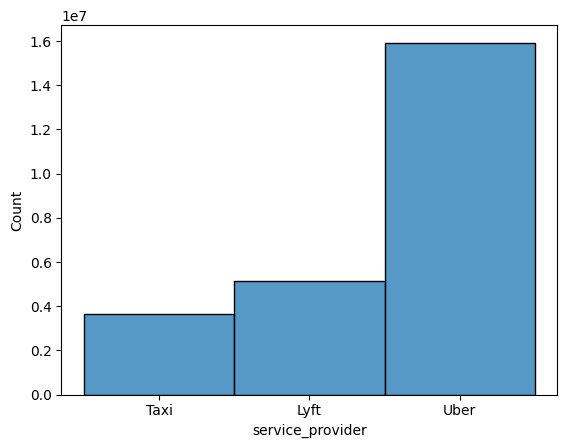

In [36]:
sns.histplot(x=trips_df['service_provider'])

<Axes: xlabel='transit_timestamp', ylabel='Count'>

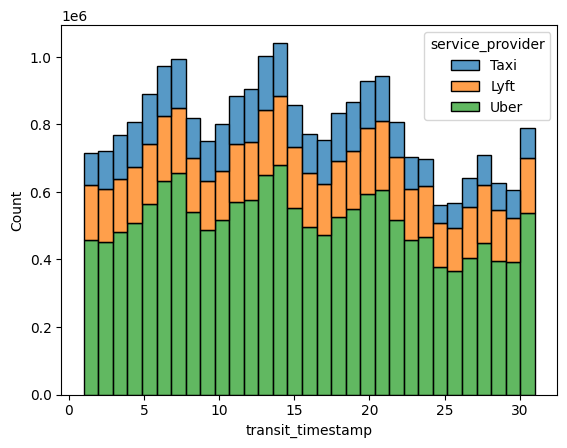

In [37]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.day, bins=31, hue='service_provider', multiple='stack')

<Axes: xlabel='transit_timestamp', ylabel='Count'>

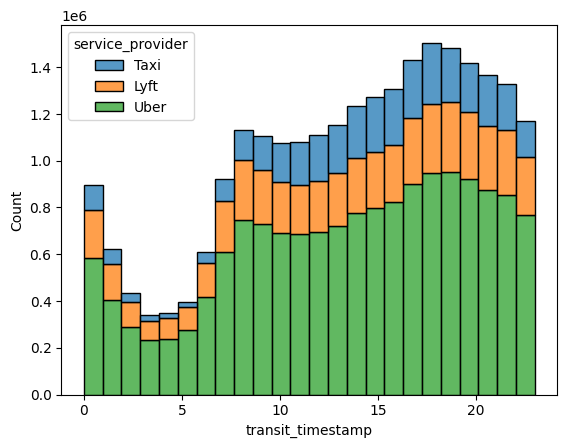

In [38]:
sns.histplot(data=trips_df, x=trips_df['transit_timestamp'].dt.hour, bins=24, hue='service_provider', multiple='stack')

<Axes: xlabel='PULocationID', ylabel='Count'>

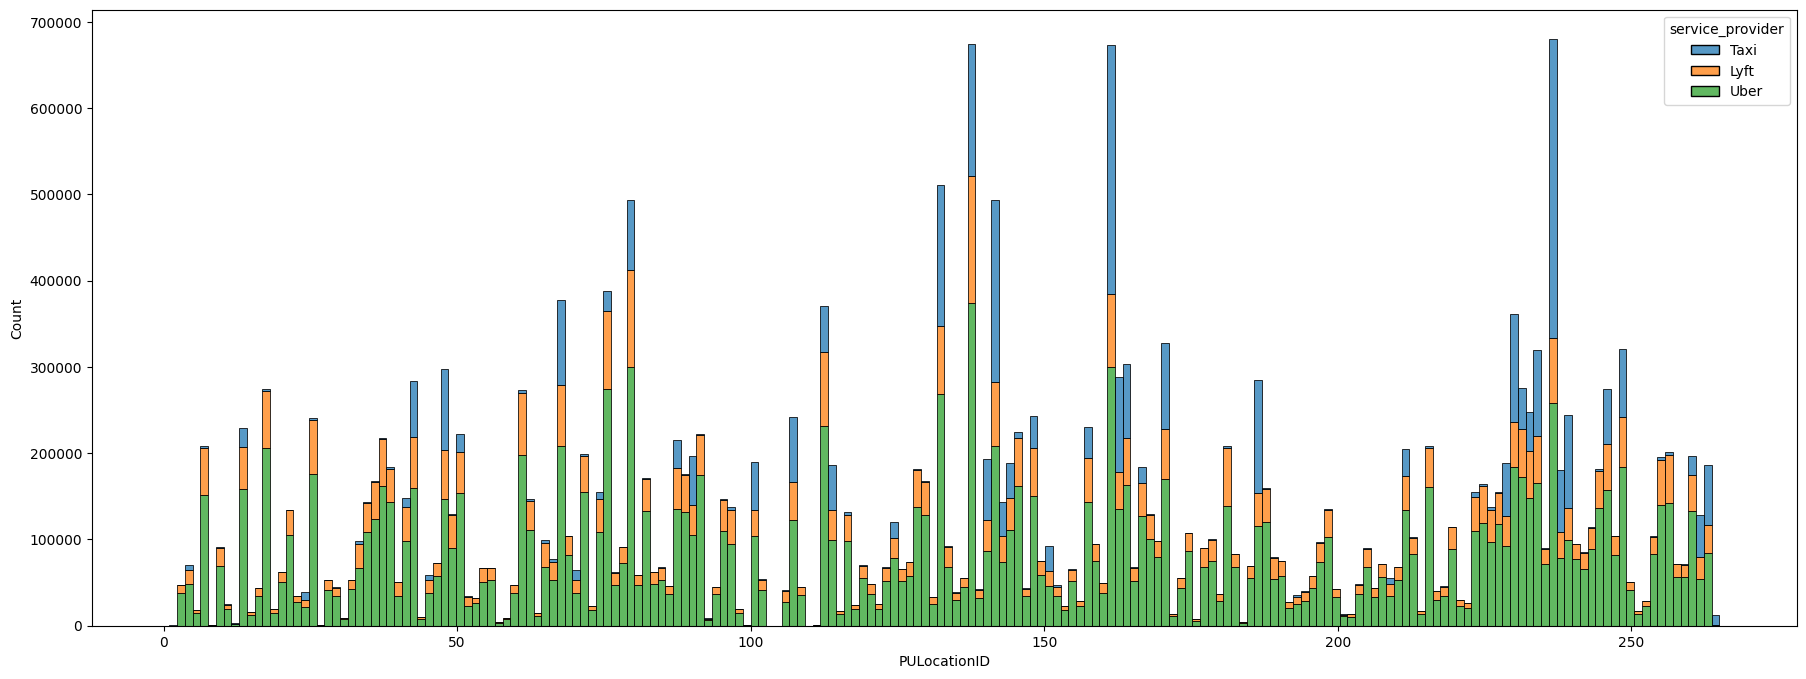

In [39]:
plt.figure(figsize=(22,8))
sns.histplot(data=trips_df, x='PULocationID', hue='service_provider', bins=200, multiple='stack')

### Permitted Events

<Axes: xlabel='event_borough', ylabel='Count'>

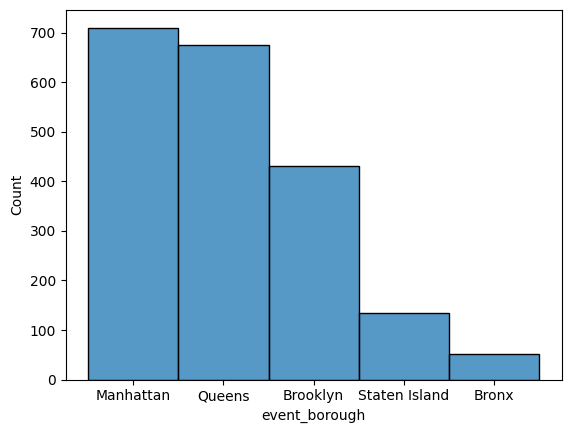

In [40]:
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['event_borough'])

Text(0.5, 1.0, 'Number of Events in a Month (per Borough)')

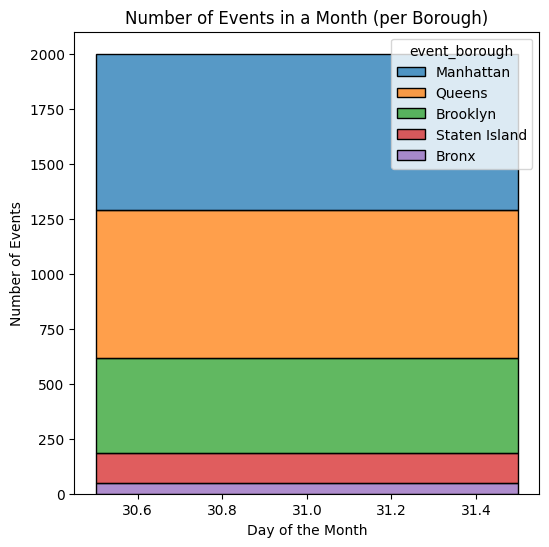

In [41]:
plt.figure(figsize=(6,6))
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.days_in_month, hue='event_borough', multiple='stack')

plt.xlabel('Day of the Month')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Month (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Week (per Borough)')

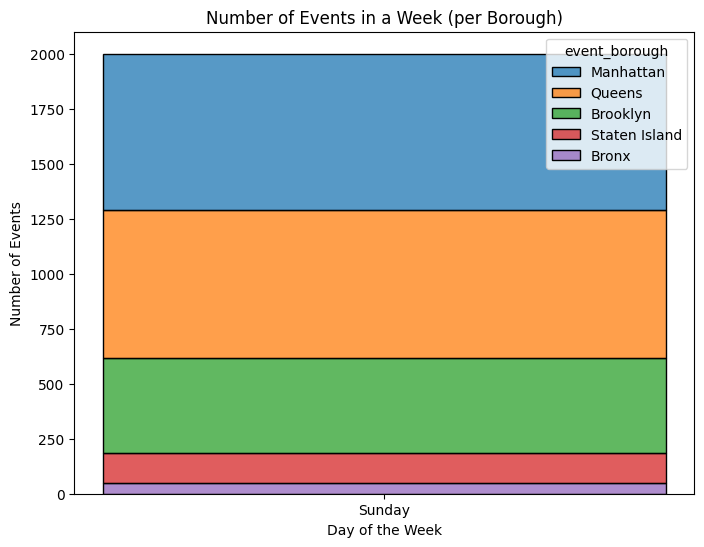

In [42]:
plt.figure(figsize=(8,6))
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.day_name(), hue='event_borough', multiple='stack')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Week (per Borough)')

Text(0.5, 1.0, 'Number of Events in a Day (per Borough)')

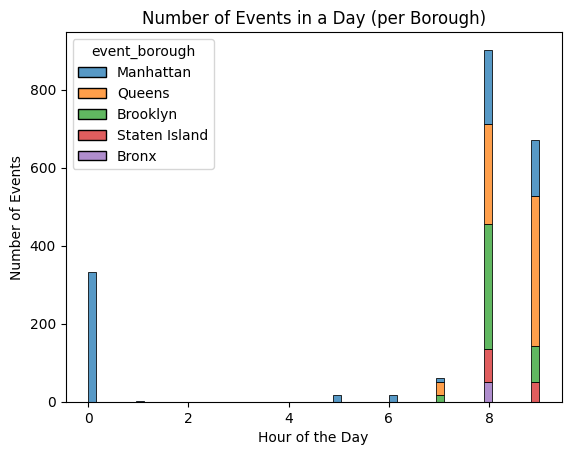

In [43]:
sns.histplot(data=permitted_events_historical_df, x=permitted_events_historical_df['start_date_time'].dt.hour, hue='event_borough', multiple='stack')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.title('Number of Events in a Day (per Borough)')

## Buses & Subways

<Axes: xlabel='transit_timestamp', ylabel='Count'>

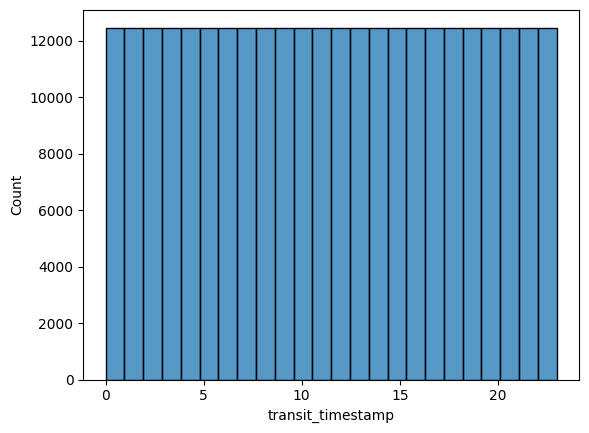

In [44]:
sns.histplot(data=bus_ridership_df, x=bus_ridership_df['transit_timestamp'].dt.hour, bins=24)

# Creating Demand DataFrame

Joining 

In [45]:
demand_df = trips_df.copy()

#demand_df['date'] = demand_df['transit_timestamp'].dt.date
#demand_df['hour'] = demand_df['transit_timestamp'].dt.hour

#demand_df.drop(columns=['transit_timestamp'],inplace=True)

demand_df= demand_df.groupby(['transit_timestamp','service_provider','PULocationID']).size().reset_index(name='number_of_rides')

In [46]:
demand_df.sample(20)

,transit_timestamp,service_provider,PULocationID,number_of_rides
814872,2024-12-02 07:55:12,Lyft,22,1
3316463,2024-12-05 13:55:41,Lyft,146,1
7699032,2024-12-10 16:54:53,Taxi,79,1
21018914,2024-12-27 11:14:50,Uber,226,1
19651483,2024-12-24 22:00:17,Uber,144,2
19053097,2024-12-24 01:00:04,Uber,148,1
1047167,2024-12-02 14:29:29,Uber,125,1
10290462,2024-12-13 16:18:17,Uber,17,1
10452573,2024-12-13 19:12:49,Uber,39,1
3146131,2024-12-05 09:21:17,Lyft,217,1


In [47]:
plt.figure(figsize=(10,6))
sns.barplot(data=demand_df,x='hour',y='number_of_rides',hue='service_provider')

plt.title("Transportation Demand by Hour")
plt.xlabel("Hour")
plt.ylabel("Demand")

ValueError: Could not interpret value `hour` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

Text(0, 0.5, 'Demand')

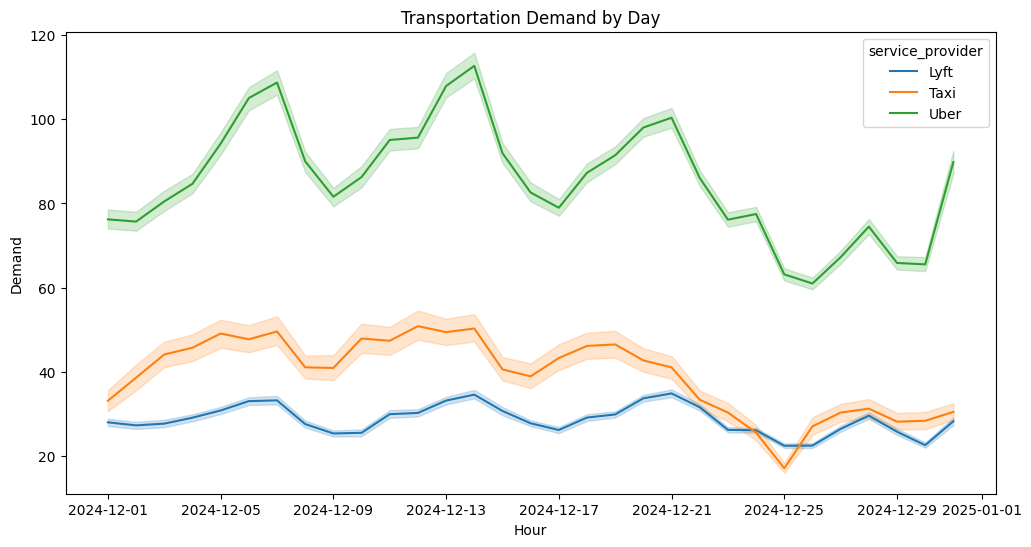

In [508]:
plt.figure(figsize=(12,6))
sns.lineplot(data=demand_df,x='date',y='number_of_rides',hue='service_provider')

plt.title("Transportation Demand by Day")
plt.xlabel("Hour")
plt.ylabel("Demand")

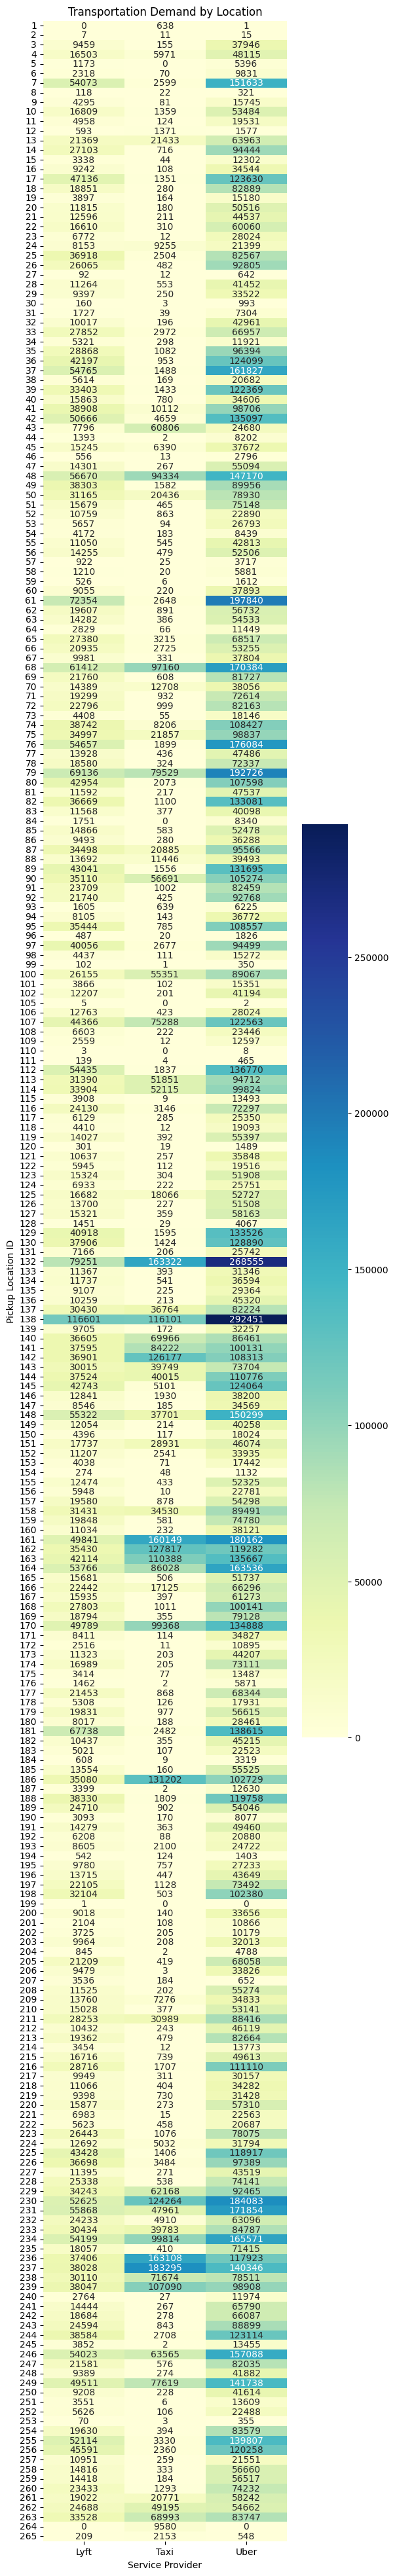

In [509]:
# Pivot the DataFrame so that rows are 'PULocationID', columns are 'service_provider', and values are 'number_of_rides'
heatmap_data = demand_df.pivot_table(
    index='PULocationID',
    columns='service_provider',
    values='number_of_rides',
    aggfunc='sum', 
    fill_value=0  # In case of missing data, fill with 0
)

plt.figure(figsize=(6, 50))
sns.heatmap(data=heatmap_data, cmap='YlGnBu', annot=True, fmt='d')

plt.title("Transportation Demand by Location")
plt.xlabel("Service Provider")
plt.ylabel("Pickup Location ID")

plt.show()